In [1]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.nn import Linear, Identity, Module
import time
import psutil

In [2]:
def print_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / (1024 ** 2):.2f} MB")

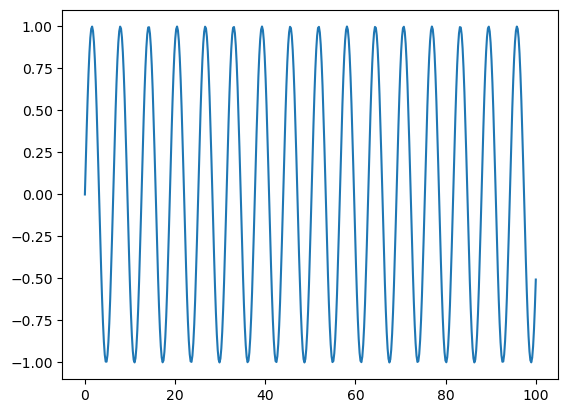

In [3]:
# Data creation 
time_steps = np.linspace(0, 100, 500)  # 500 time steps between 0 and 100
data = np.sin(time_steps)  # Generate sine wave

# Create a DataFrame
df = pd.DataFrame(data, columns=['Value'])
df['Time'] = time_steps

plt.plot(df['Time'], df['Value'])
plt.show()

data = df['Value'].values.reshape(-1, 1)  # Reshape to 2D array
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences from the data
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 10  # Predict based on 10 past time steps
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size = 16, shuffle=False)

In [4]:
# Appendix B.1

def parallel_scan_log(log_coeffs, log_values):
    # log_coeffs: (batch_size, seq_len, input_size)
    # log_values: (batch_size, seq_len + 1, input_size)
    a_star = F.pad(torch.cumsum(log_coeffs, dim = 1), (0, 0, 1, 0))
    log_h0_plus_b_star = torch.logcumsumexp(log_values - a_star, dim = 1)
    log_h = a_star + log_h0_plus_b_star
    return torch.exp(log_h)[:, 1:]

# Appendix B.3

def g(x):
    return torch.where(x >= 0, x+0.5, torch.sigmoid(x))
def log_g(x):
    return torch.where(x >= 0, (F.relu(x)+0.5).log(),-F.softplus(-x))

class GRUCell(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear_z = nn.Linear(in_dim, out_dim)
        self.linear_h = nn.Linear(in_dim, out_dim)

    def forward(self, inputs, hidden_state):
        k = self.linear_z(inputs)
        log_z = -1*F.softplus(-k)
        log_coeffs = -1*F.softplus(k)
        log_h_0 = log_g(hidden_state)
        log_tilde_h = log_g(self.linear_h(inputs))
        h = parallel_scan_log(log_coeffs, torch.cat([log_h_0, log_z + log_tilde_h], dim=1))
        return h

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.gru_cell = GRUCell(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        hidden_state = torch.zeros(batch_size, 1, self.hidden_dim, device=x.device) # Must include dimension of 1 for GRUCell
        hidden_state = self.gru_cell(x, hidden_state)
        output = self.fc(hidden_state)
        return output[:, -1, :]

try:
    device = torch.device('cpu') # NotImplementedError: The operator 'aten::_logcumsumexp' is not currently implemented for the MPS device.
except:
    raise Exception("No MPS found")

input_dim = 1
hidden_dim = 50
output_dim = 1
learning_rate = 0.001
epochs = 20

# Initialize model, loss function, optimizer
model = GRUModel(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

n_epochs = 10
for i in (range(n_epochs)):
    train_loss = 0
    n_batches = 0
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.detach().cpu().item()
        n_batches+=1
    train_loss/=n_batches

    test_loss = 0
    n_batches = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            loss = criterion(out, y)
            test_loss += loss.detach().cpu().item()
            n_batches += 1
    test_loss/=n_batches

    print(f"=== Epoch: {i+1} | Training loss: {train_loss:.2f} | Testing loss: {test_loss:.2f} ====")
print(f"Total time taken: {time.time()-start_time:.2f}s")
print_memory_usage()

=== Epoch: 1 | Training loss: 0.33 | Testing loss: 0.10 ====
=== Epoch: 2 | Training loss: 0.10 | Testing loss: 0.09 ====
=== Epoch: 3 | Training loss: 0.08 | Testing loss: 0.07 ====
=== Epoch: 4 | Training loss: 0.07 | Testing loss: 0.06 ====
=== Epoch: 5 | Training loss: 0.06 | Testing loss: 0.05 ====
=== Epoch: 6 | Training loss: 0.05 | Testing loss: 0.04 ====
=== Epoch: 7 | Training loss: 0.04 | Testing loss: 0.03 ====
=== Epoch: 8 | Training loss: 0.03 | Testing loss: 0.03 ====
=== Epoch: 9 | Training loss: 0.03 | Testing loss: 0.02 ====
=== Epoch: 10 | Training loss: 0.02 | Testing loss: 0.02 ====
Total time taken: 0.64s
Memory Usage: 405.72 MB
